<a href="https://www.kaggle.com/code/nigamshitij/ml-recap-xgboost?scriptVersionId=180572847" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import sklearn
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV # cross validation / test diff parameters
from sklearn.metrics import confusion_matrix # create
from sklearn.metrics import ConfusionMatrixDisplay # draw # older is plot_confusion_matrix

In [16]:
# import data / read head
excel_path = '/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx'
df = pd.read_excel(excel_path)
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [17]:
dropped_cols = ['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason']
df.drop(
    dropped_cols, 
    axis = 1, # axis = 1, columns
    inplace = True
    )
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [18]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000


In [19]:
# get number of uniques for each column
df.nunique()

CustomerID           7043
Count                   1
Country                 1
State                   1
City                 1129
Zip Code             1652
Lat Long             1652
Latitude             1652
Longitude            1651
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          73
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Monthly Charges      1585
Total Charges        6531
Churn Value             2
dtype: int64

In [20]:
omit_cols = ['CustomerID', 'Count', 'Country', 'State', 'Lat Long']
df.drop(
    omit_cols, 
    axis = 1, # axis = 1, columns
    inplace = True
    )
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [21]:
# clean up
df['City'].replace(
    ' ', 
    '_', 
    regex = True,
    inplace = True
)
df.head()

/tmp/ipykernel_33/3694608323.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['City'].replace(


,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [22]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

In [24]:
# Replce column names
df.columns = df.columns.str.replace(' ', '_')
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [25]:
# missing data :(
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [26]:
df['Phone_Service'].unique()

array(['Yes', 'No'], dtype=object)

In [28]:
df['Total_Charges'].unique()

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

In [32]:
# df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
# returns ValueError: Unable to parse string " " at position 2234
print(len(df.loc[df['Total_Charges'] == ' ']))
print(len(df))

11
7043


In [33]:
df.loc[df['Total_Charges'] == ' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [35]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0
df.loc[df['Tenure_Months'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


In [37]:
# convert total charges to float
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

In [38]:
# replace entire blankspaces with underscore (hopefully this shouldn't apply to ints)
# xgboost doesn't care but this is useful for tree prints
df.replace(' ', '_', regex = True, inplace = True)
print(df.head())
print(df.describe())
print(df.dtypes)

          City  Zip_Code   Latitude   Longitude  Gender Senior_Citizen  \
0  Los_Angeles     90003  33.964131 -118.272783    Male             No   
1  Los_Angeles     90005  34.059281 -118.307420  Female             No   
2  Los_Angeles     90006  34.048013 -118.293953  Female             No   
3  Los_Angeles     90010  34.062125 -118.315709  Female             No   
4  Los_Angeles     90015  34.039224 -118.266293    Male             No   

  Partner Dependents  Tenure_Months Phone_Service  ... Device_Protection  \
0      No         No              2           Yes  ...                No   
1      No        Yes              2           Yes  ...                No   
2      No        Yes              8           Yes  ...               Yes   
3     Yes        Yes             28           Yes  ...               Yes   
4      No        Yes             49           Yes  ...               Yes   

  Tech_Support Streaming_TV Streaming_Movies        Contract  \
0           No           No       

In [39]:
# split into X, Y :)
# we want to predict churn value, 1 for left and 0 for those who didn't
X = df.drop('Churn_Value', axis = 1).copy()
print(X.head())

y = df['Churn_Value'].copy()
print(y.head())

          City  Zip_Code   Latitude   Longitude  Gender Senior_Citizen  \
0  Los_Angeles     90003  33.964131 -118.272783    Male             No   
1  Los_Angeles     90005  34.059281 -118.307420  Female             No   
2  Los_Angeles     90006  34.048013 -118.293953  Female             No   
3  Los_Angeles     90010  34.062125 -118.315709  Female             No   
4  Los_Angeles     90015  34.039224 -118.266293    Male             No   

  Partner Dependents  Tenure_Months Phone_Service  ... Online_Backup  \
0      No         No              2           Yes  ...           Yes   
1      No        Yes              2           Yes  ...            No   
2      No        Yes              8           Yes  ...            No   
3     Yes        Yes             28           Yes  ...            No   
4      No        Yes             49           Yes  ...           Yes   

  Device_Protection Tech_Support Streaming_TV Streaming_Movies  \
0                No           No           No           

In [45]:
# one hot encoding - aim is to avoid converting categories directly to numbers since it gets treated like continuous data
# older versions default to int, new version defaults to bool
pd.get_dummies(X, columns = ['Payment_Method'], dtype = 'int64').head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,Yes,Month-to-month,Yes,99.65,820.50,0,0,1,0
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Month-to-month,Yes,104.80,3046.05,0,0,1,0
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,Month-to-month,Yes,103.70,5036.30,1,0,0,0


In [49]:
X_columns = X.columns.values
X_columns_encoded = ['City', 'Gender',
       'Senior_Citizen', 'Partner', 'Dependents', 
       'Phone_Service', 'Multiple_Lines', 'Internet_Service',
       'Online_Security', 'Online_Backup', 'Device_Protection',
       'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Contract',
       'Paperless_Billing', 'Payment_Method']

In [50]:
X_encoded = pd.get_dummies(
    X,
    columns = X_columns_encoded,
    dtype = 'int64'
)
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


In [67]:
X_encoded.dtypes

Zip_Code                                      int64
Latitude                                    float64
Longitude                                   float64
Tenure_Months                                 int64
Monthly_Charges                             float64
                                             ...   
Paperless_Billing_Yes                         int64
Payment_Method_Bank_transfer_(automatic)      int64
Payment_Method_Credit_card_(automatic)        int64
Payment_Method_Electronic_check               int64
Payment_Method_Mailed_check                   int64
Length: 1178, dtype: object

In [54]:
y.unique()

array([1, 0])

In [55]:
print("% left in y: ", sum(y)/len(y))
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42, stratify = y) # to ensure similar % splits
print("% left in y_train: ", sum(y_train)/len(y_train))
print("% left in y_test: ", sum(y_test)/len(y_test))

% left in y:  0.2653698707936959
% left in y_train:  0.2654297614539947
% left in y_test:  0.26519023282226006


In [68]:
# classifier

clf = xgb.XGBClassifier(
    # learning task + corresponding learning objective - classify as 1 or 0
    objective = 'binary:logistic',
    # tell xgboost what character we use - default is 0 when specified as None
#     missing = None, 
    # random state instead of seed
    random_state = 42,
    # move early stopping rounds & eval metric into initialization
    early_stopping_rounds = 10,
    eval_metric = 'aucpr', # https://xgboost.readthedocs.io/en/stable/parameter.html
)

clf.fit(
    X_train,
    y_train,
    eval_set = [(X_test, y_test)],
    verbose = True,
)

[0]	validation_0-aucpr:0.64135
[1]	validation_0-aucpr:0.65171
[2]	validation_0-aucpr:0.65991
[3]	validation_0-aucpr:0.65350
[4]	validation_0-aucpr:0.65743
[5]	validation_0-aucpr:0.65051
[6]	validation_0-aucpr:0.65827
[7]	validation_0-aucpr:0.65980
[8]	validation_0-aucpr:0.65751
[9]	validation_0-aucpr:0.65389
[10]	validation_0-aucpr:0.65572
[11]	validation_0-aucpr:0.65920
[12]	validation_0-aucpr:0.66010
[13]	validation_0-aucpr:0.65963
[14]	validation_0-aucpr:0.65877
[15]	validation_0-aucpr:0.65791
[16]	validation_0-aucpr:0.65808
[17]	validation_0-aucpr:0.65742
[18]	validation_0-aucpr:0.65770
[19]	validation_0-aucpr:0.65698
[20]	validation_0-aucpr:0.65733
[21]	validation_0-aucpr:0.65646


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

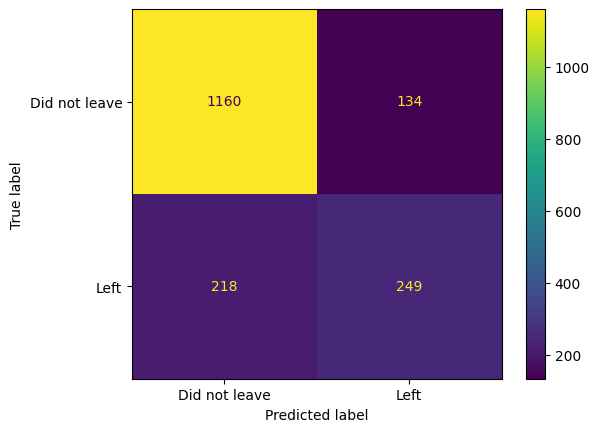

In [69]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    values_format = 'd',
    display_labels = ['Did not leave', 'Left']
)